In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from utils import import_data, get_accuracy, get_accuracy_by_cue, plot_accuracy, plot_accuracy_by_cue, save_fig
from supplemental_data import rule_change, cscheme, cue_names

import datetime
timestamp = datetime.datetime.today().strftime("%Y-%m-%d-%H%M%S")

# Import data
Specify the list of all animals and the directory the csv files are. Choose a subset of animals to work with.

In [2]:
all_animals = [
    'JC240',
    'JC241',
    'JC258',
    'JC267',
    'JC274',
    'JC283',
]

datadir = 'data/'

animals = all_animals[2:]

Import animal data and store them in a dict under animal name.

In [3]:
data = {}

for animal in animals:
    data[animal] = import_data(datadir,
                               animal)

Get the number of training days for each animal.

In [4]:
sessions = {}

for animal in animals:
    sessions[animal] = data[animal]['Session_ID'].unique()

Calculate the accuracy for each training day.

In [5]:
accuracy = {}

for animal in animals:
    accuracy[animal] = get_accuracy(data,
                                    animal)

Get the unique food cues for each experiment. Calculate the accuracy by training day and food cue type.

In [6]:
cues = {}
accuracy_by_cue = {}

for animal in animals:
    cues[animal] = data[animal]['Flavor'].unique()
    accuracy_by_cue[animal] = get_accuracy_by_cue(data,
                                                  animal)

# Plotting

## Plot accuracy before rule change

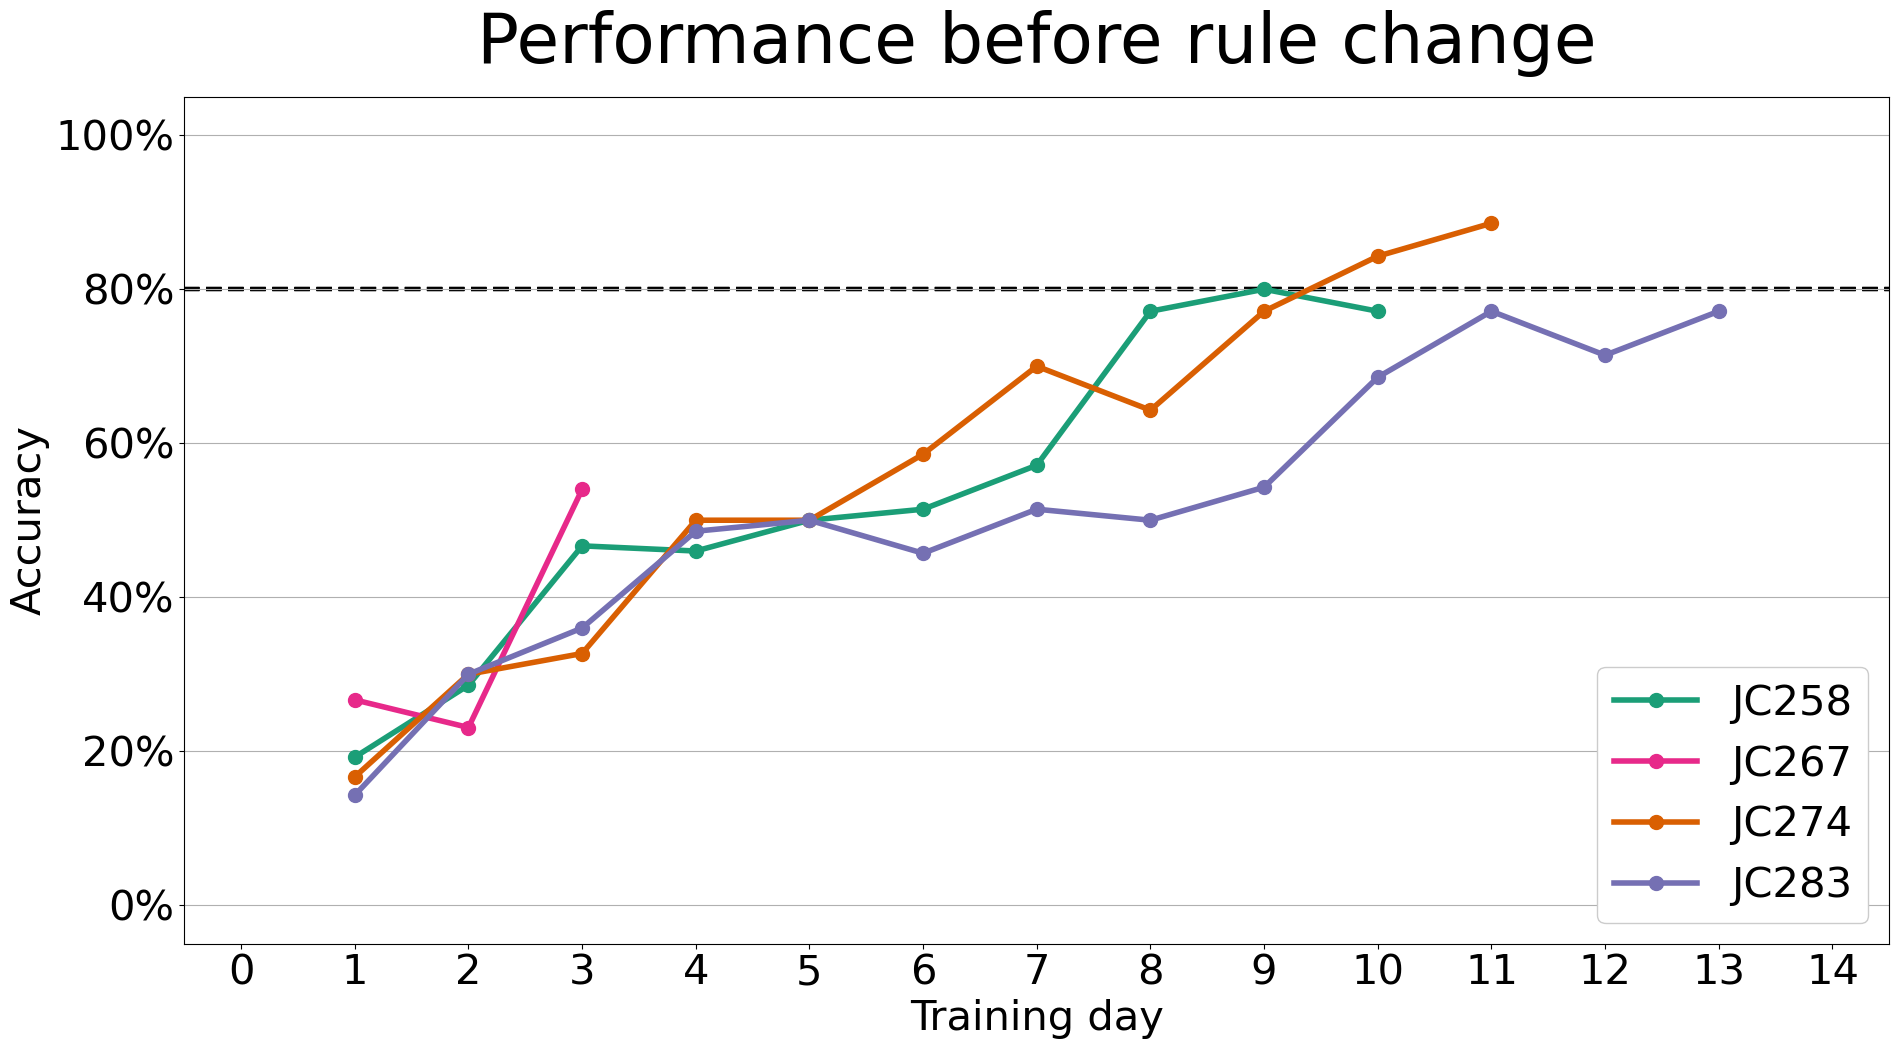

In [7]:
fig, ax = plt.subplots(figsize=(22,11))
title='Performance before rule change'

for animal in animals:
    acc = accuracy[animal].iloc[:rule_change[animal]-1] # accuracy before rule change
    plot_accuracy(acc,
                  animal,
                  ndays=14,
                  title=title,
                  fig=fig,
                  ax=ax)

plt.show()
# save_fig('Performance 2cues', 'svg')

## Plot accuracy after rule change

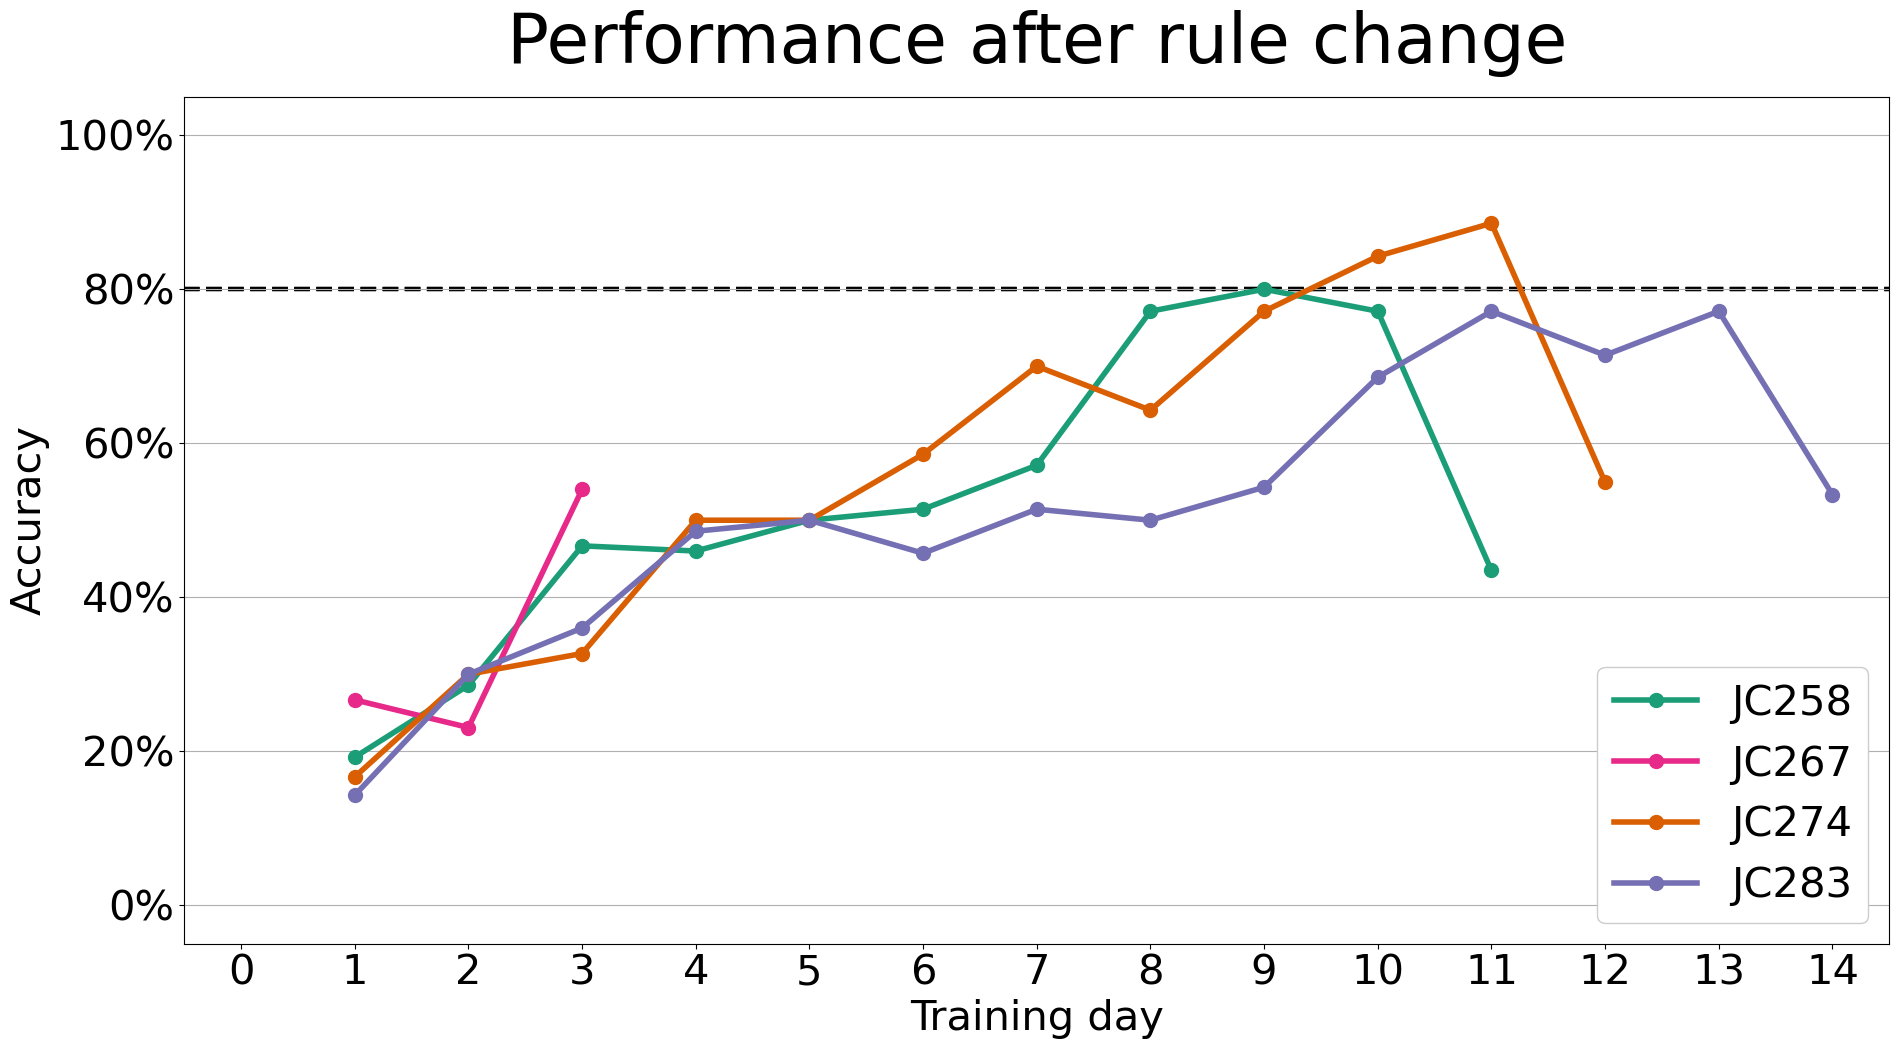

In [8]:
fig, ax = plt.subplots(figsize=(22,11))
title='Performance after rule change'

for animal in animals:
    acc = accuracy[animal].iloc[:rule_change[animal]] # accuracy before rule change
    plot_accuracy(acc,
                  animal,
                  ndays=14,
                  title=title,
                  fig=fig,
                  ax=ax)

# save_fig('Performance 3cues', 'svg')

## Plot performance by cue type (all animals)

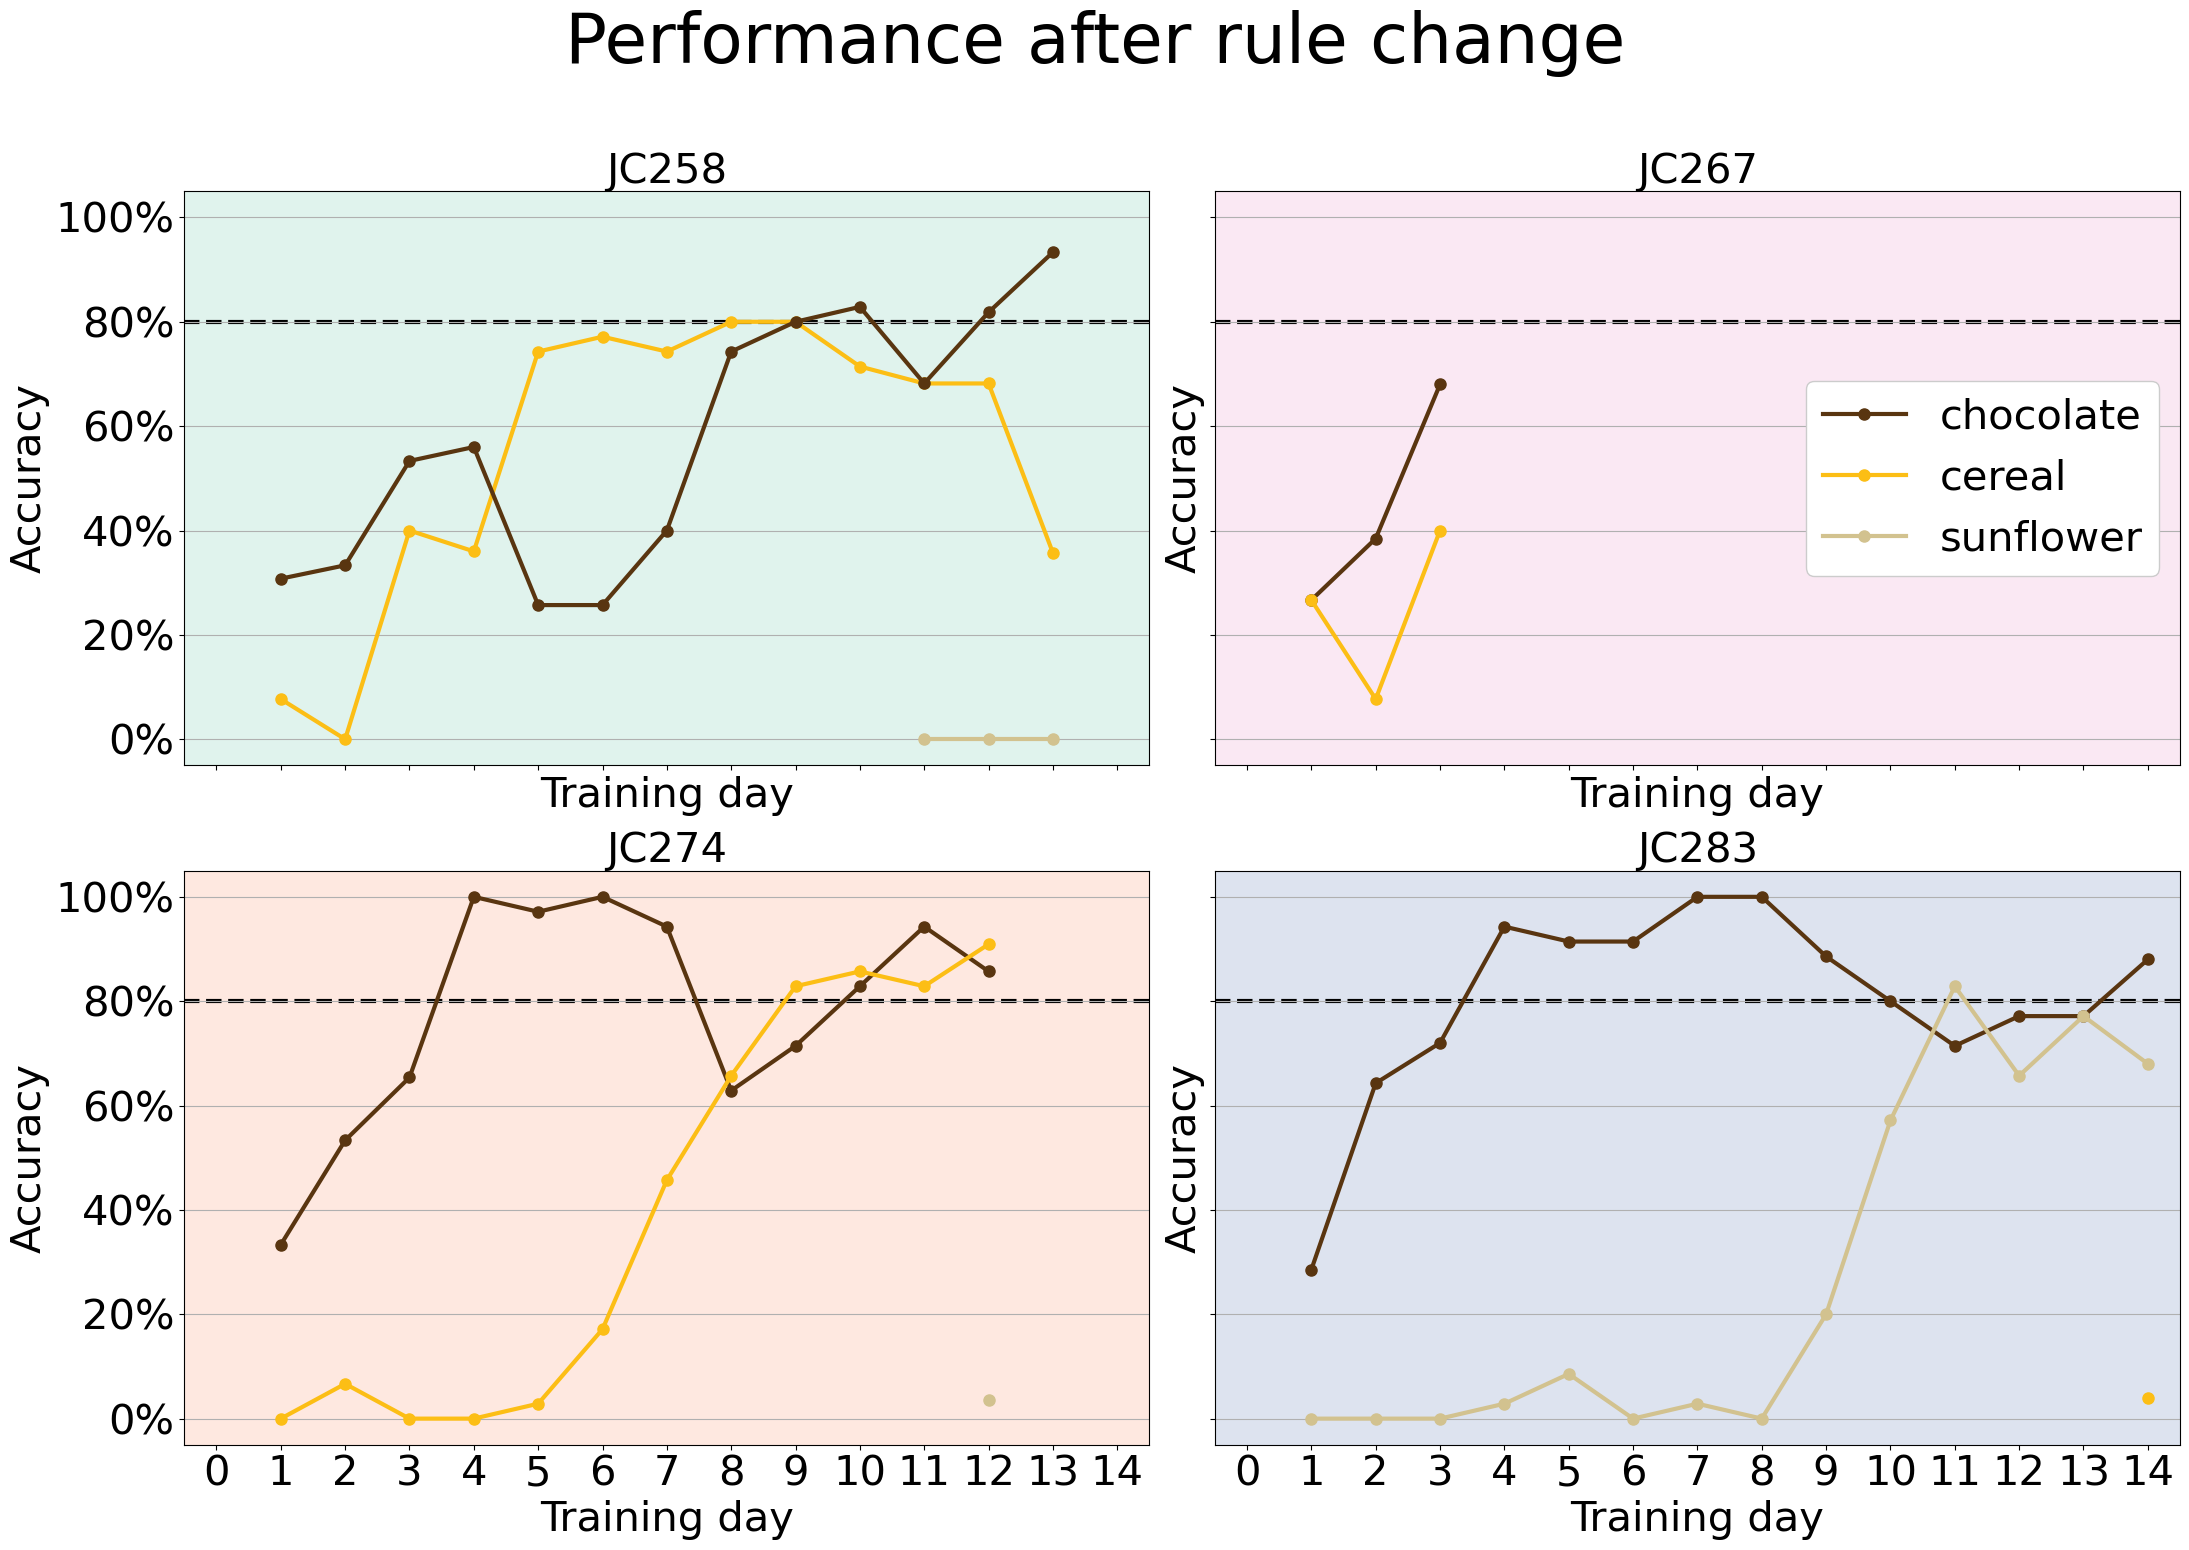

In [9]:
ndays=14 # set the number of days to plot

# Make a large plot with 4 subplots
rows, cols = 2, 2
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(22,15))
fig.suptitle(title, fontsize=50, y=1.03)
title='Performance by cue type'

# Iterate over each subplot and plot
for ax, animal in zip(axes.flatten(), animals):
    plot_accuracy_by_cue(accuracy_by_cue[animal],
                         animal,
                         cues[animal],
                         ndays,
                         fig=fig,
                         ax=ax,
                         background=cscheme[animal+'_light'])
    
    # Plot legend on JC267 subplot
    if animal == 'JC267':
        legend_handles = []
        for cue, color in cue_names.items():
            legend_handles.append(plt.Line2D([],[], color=color, label=cue, linewidth=3, marker='o', markersize=8))
        ax.legend(handles=legend_handles, loc=7, fontsize=30, framealpha=1)
        
# save_fig('Performance all animals light tint', 'svg')

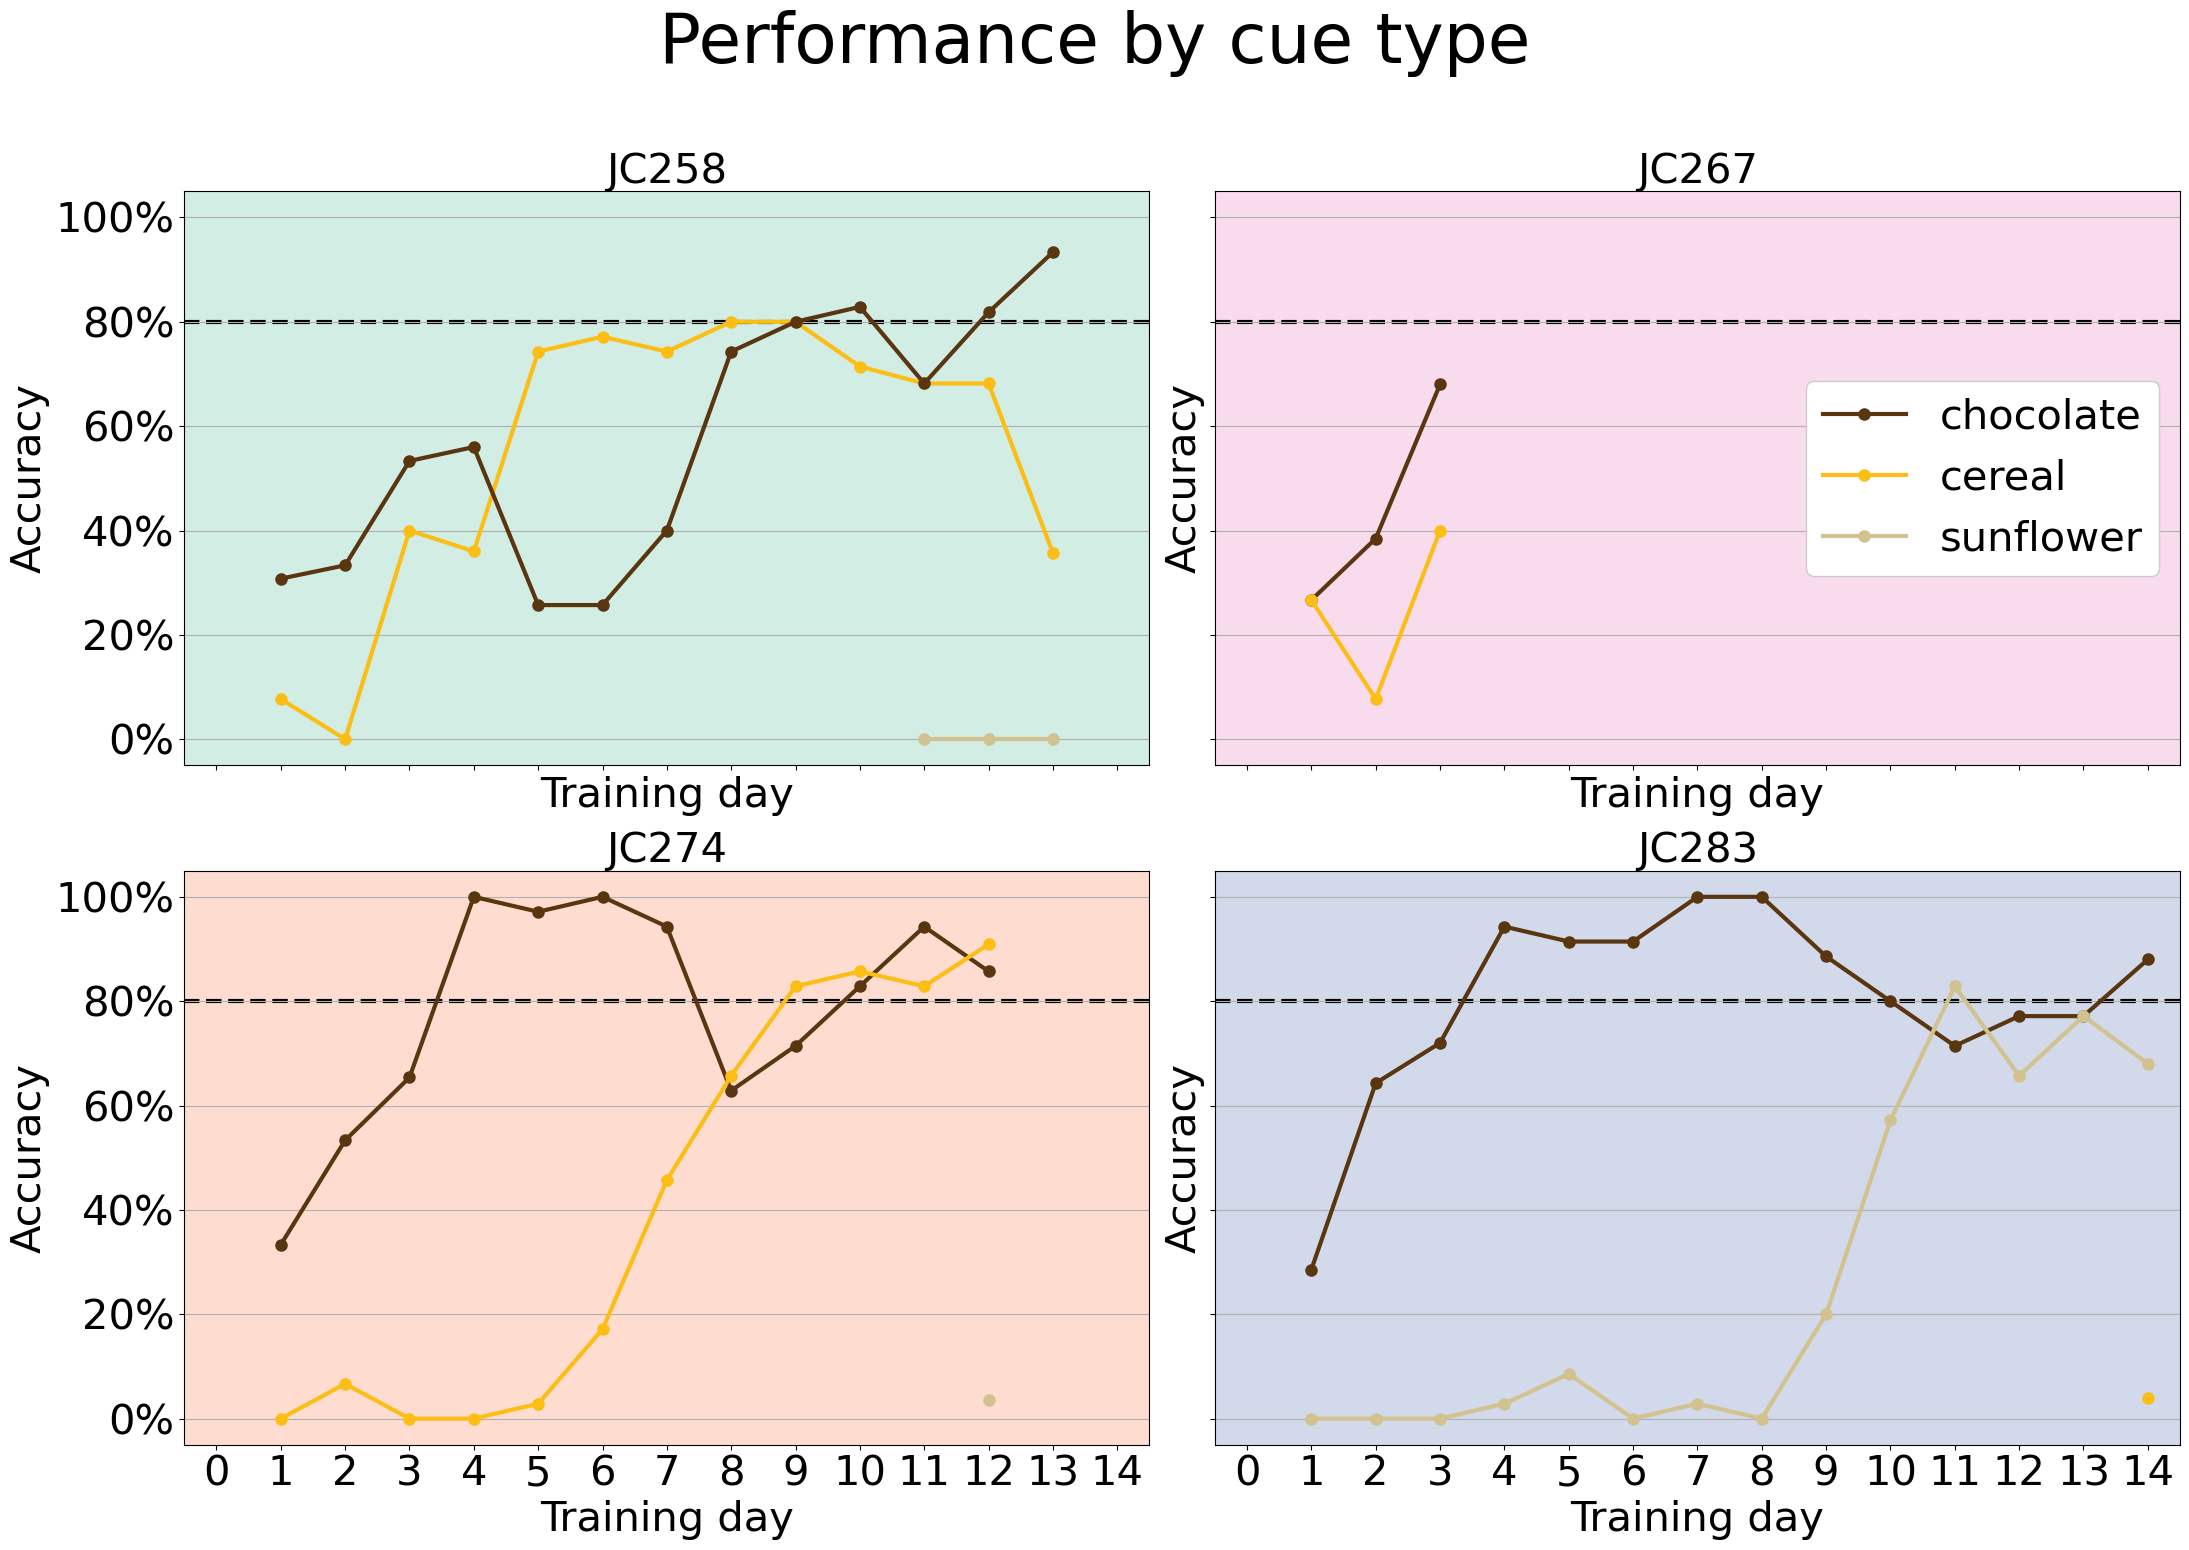

In [10]:
ndays=14 # set the number of days to plot

# Make a large plot with 4 subplots
rows, cols = 2, 2
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(22,15))
fig.suptitle(title, fontsize=50, y=1.03)
title='Performance by cue type'

# Iterate over each subplot and plot
for ax, animal in zip(axes.flatten(), animals):
    plot_accuracy_by_cue(accuracy_by_cue[animal],
                         animal,
                         cues[animal],
                         ndays,
                         fig=fig,
                         ax=ax,
                         background=cscheme[animal+'_medium'])
    
    # Plot legend on JC267 subplot
    if animal == 'JC267':
        legend_handles = []
        for cue, color in cue_names.items():
            legend_handles.append(plt.Line2D([],[], color=color, label=cue, linewidth=3, marker='o', markersize=8))
        ax.legend(handles=legend_handles, loc=7, fontsize=30, framealpha=1)
        
# save_fig('Performance all animals medium tint', 'svg')

## Plot performance by cue type (individual animals)

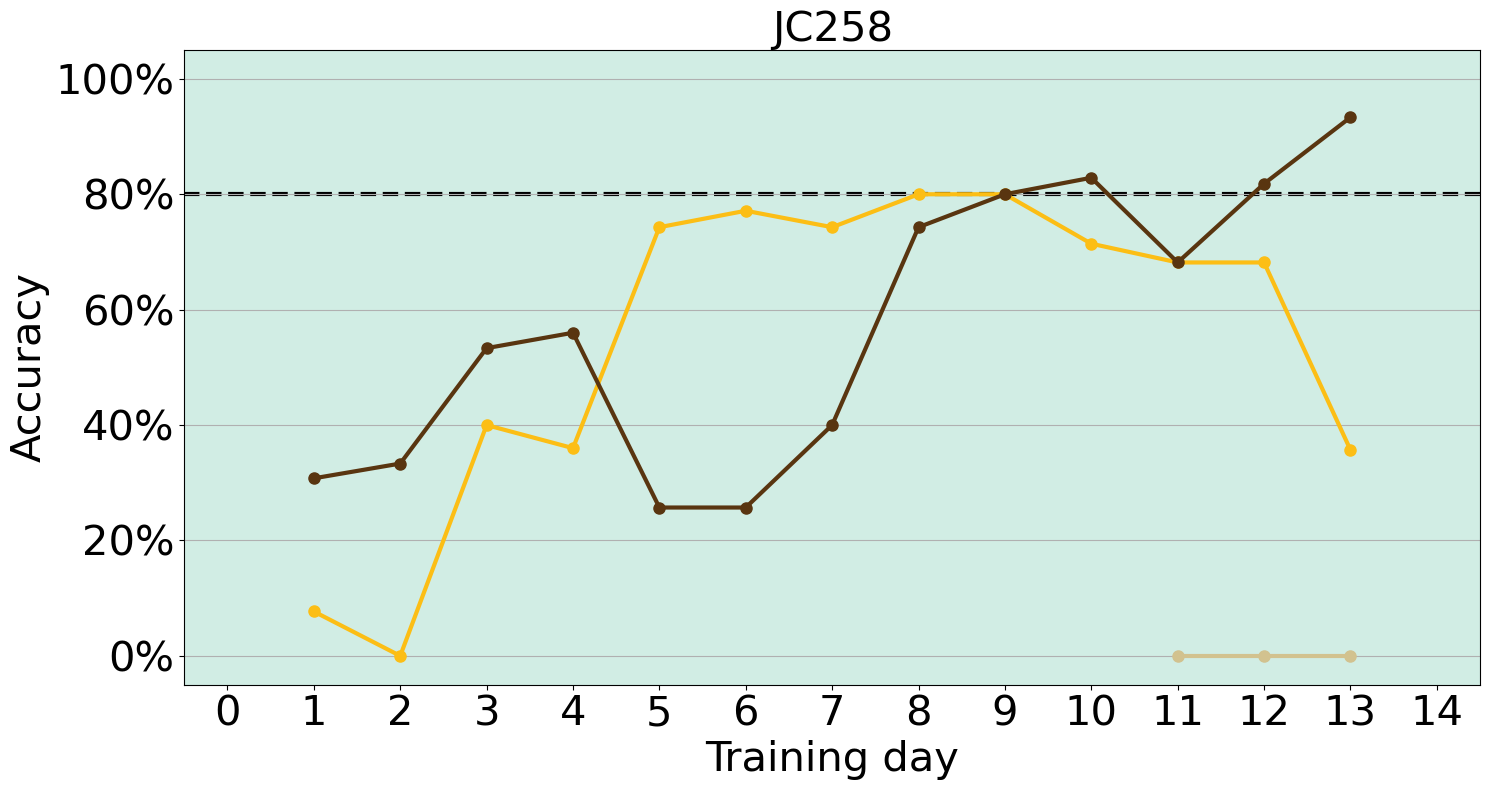

In [12]:
animal='JC258'
plot_accuracy_by_cue(accuracy_by_cue[animal],
                     animal,
                     cues[animal],
                     ndays,
                     background=cscheme[animal+'_medium']
                    )

# save_fig(f'Performance {animal}', 'svg')

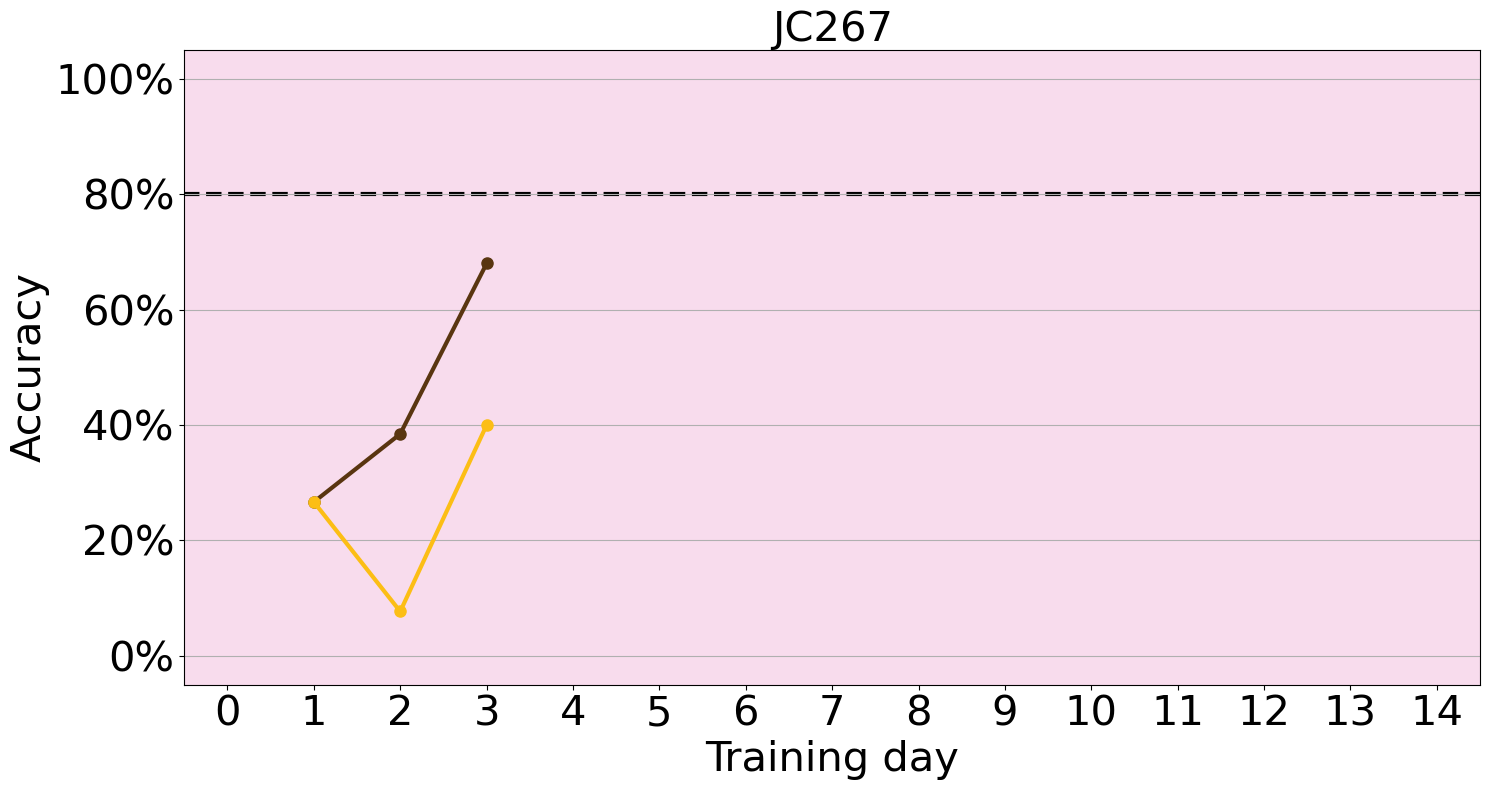

In [17]:
animal='JC267'
plot_accuracy_by_cue(accuracy_by_cue[animal],
                     animal,
                     cues[animal],
                     ndays,
                     background=cscheme[animal+'_medium']
                    )

# save_fig(f'Performance {animal}', 'svg')

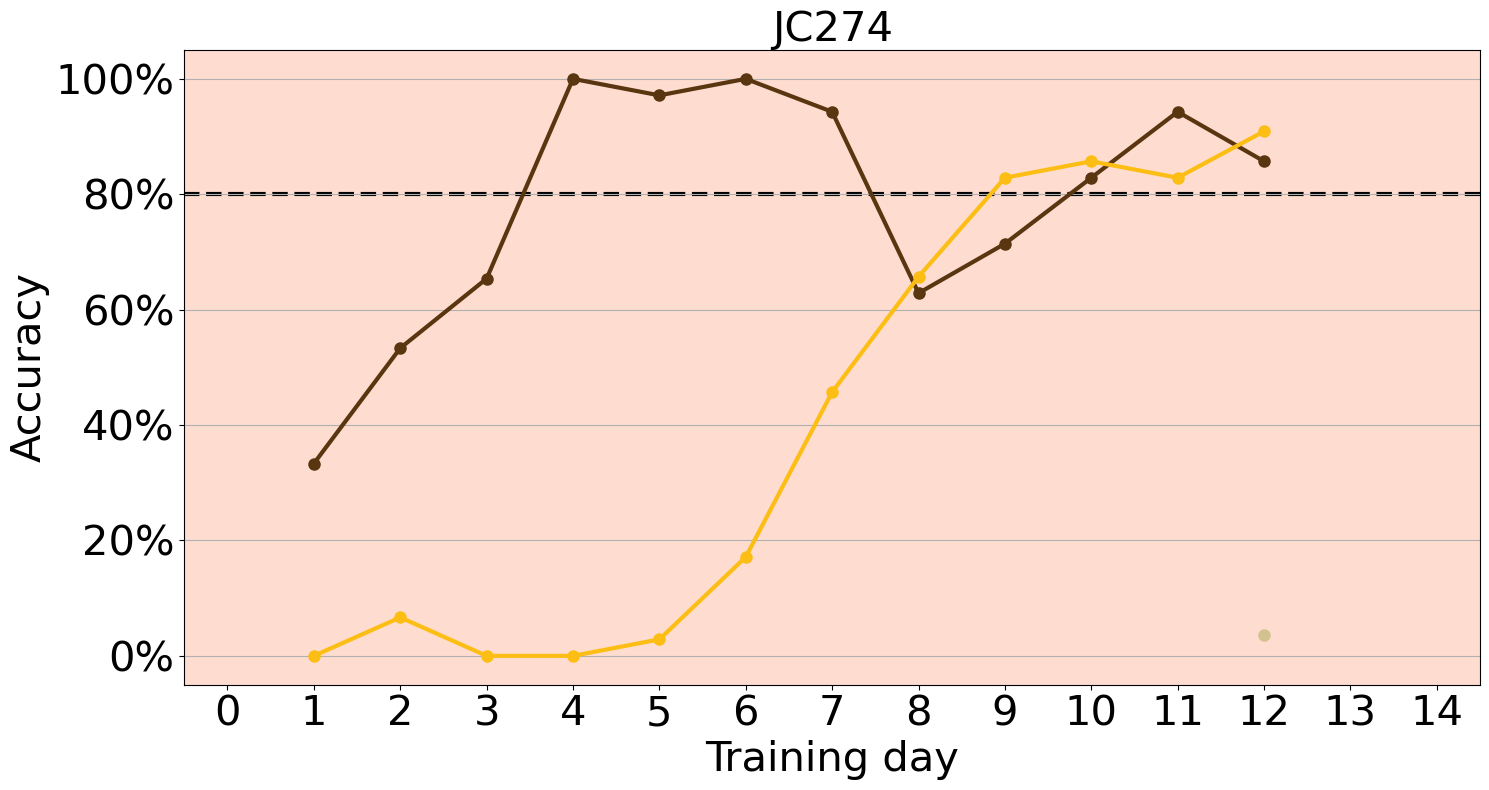

In [19]:
animal='JC274'
plot_accuracy_by_cue(accuracy_by_cue[animal],
                     animal,
                     cues[animal],
                     ndays,
                     background=cscheme[animal+'_medium']
                    )

# save_fig(f'Performance {animal}', 'svg')

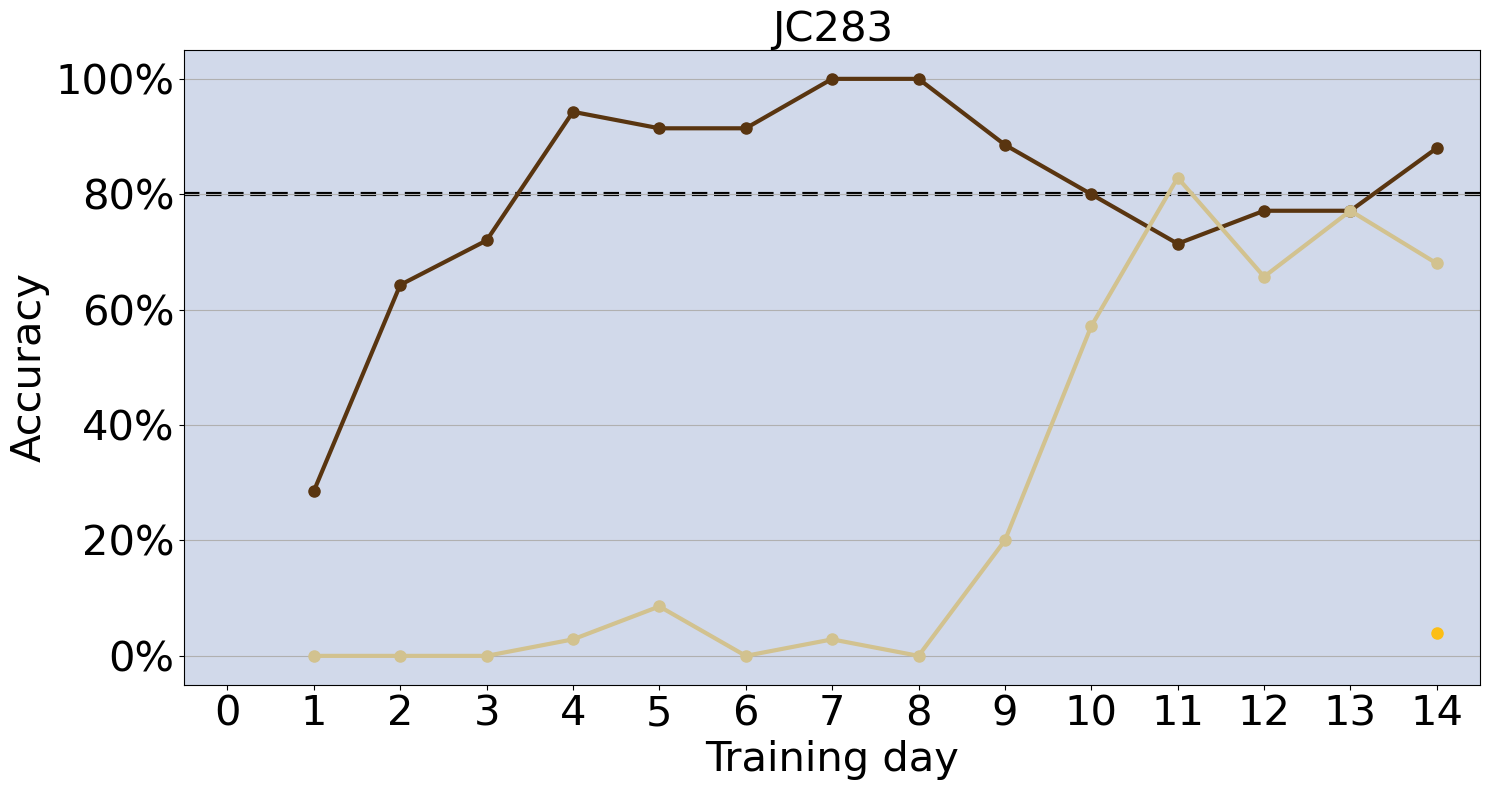

In [21]:
animal='JC283'
plot_accuracy_by_cue(accuracy_by_cue[animal],
                     animal,
                     cues[animal],
                     ndays,
                     background=cscheme[animal+'_medium']
                    )

# save_fig(f'Performance {animal}', 'svg')